# Correlation of forecasted and observed lower tercile precipitation
This notebook explores the occurrence of below average precipitation in Burkina Faso. This is thereafter used to assess the skill of below average forecasts. 
The area of interest for the pilot are 4 admin1 areas: Boucle de Mounhoun, Centre Nord, Sahel, and Nord. Therefore this analysis is mainly focussed on those areas

The proposal contains two triggers as outlined below. We therefore mainly focus on the stated seasons (=3month period). However, for a part of the analysis we include all seasons due to only having forecast data of the last 4 years. 

We solely experiment with the 40% threshold, as the 50% threshold was never met during the last 4 years. 
- Trigger #1 in March covering Apr-May-June. Threshold desired: 40%.
- Trigger #2 in July covering Aug-Sep-Oct. Threshold desired: 50%.

#TODO: change df_obsfor to df_obsfor_l1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import geopandas as gpd
from shapely.geometry import mapping
import pandas as pd
import rioxarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from rasterstats import zonal_stats
from IPython.display import Markdown as md
from myst_nb import glue
from dateutil.relativedelta import relativedelta
import math
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from src.indicators.drought.config import Config

from src.indicators.drought.iri_rainfallforecast import get_iri_data

In [3]:
country="bfa"
country_iso3="bfa"
adm_sel=["Boucle du Mouhoun","Nord","Centre-Nord","Sahel"]
config=Config()
parameters = config.parameters(country)
data_raw_dir=os.path.join(config.DATA_DIR,config.PUBLIC_DIR,config.RAW_DIR)
data_processed_dir=os.path.join(config.DATA_DIR,config.PUBLIC_DIR,config.PROCESSED_DIR)
country_data_raw_dir = os.path.join(data_raw_dir,country_iso3)
country_data_exploration_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR,"exploration",country)
glb_data_raw_dir = os.path.join(data_raw_dir,"glb")
chirps_monthly_raw_dir = os.path.join(glb_data_raw_dir,"chirps","monthly")
chirps_country_processed_dir = os.path.join(data_processed_dir,country,"chirps")

chirps_monthly_path=os.path.join(chirps_monthly_raw_dir,"chirps_glb_monthly.nc")
chirps_country_processed_path = os.path.join(chirps_country_processed_dir,"monthly",f"{country}_chirps_monthly.nc")
chirps_seasonal_lower_tercile_processed_path = os.path.join(chirps_country_processed_dir,"seasonal",f"{country}_chirps_seasonal_lowertercile.nc")
stats_reg_for_path=os.path.join(country_data_exploration_dir,f"{country}_iri_seasonal_forecast_stats_{''.join(adm_sel)}.csv")

adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [4]:
month_season_mapping={1:"NDJ",2:"DJF",3:"JFM",4:"FMA",5:"MAM",6:"AMJ",7:"MJJ",8:"JJA",9:"JAS",10:"ASO",11:"SON",12:"OND"}

## Analyzing observed precipitation patterns
Before we compare the forecasts and observations, we first have a look at the observational data to better understand the precipitation patterns in Burkina Faso. 

Below the total precipitation during each month of 2020 is plotted. We can clearly see that most rainfall is received between June and September.

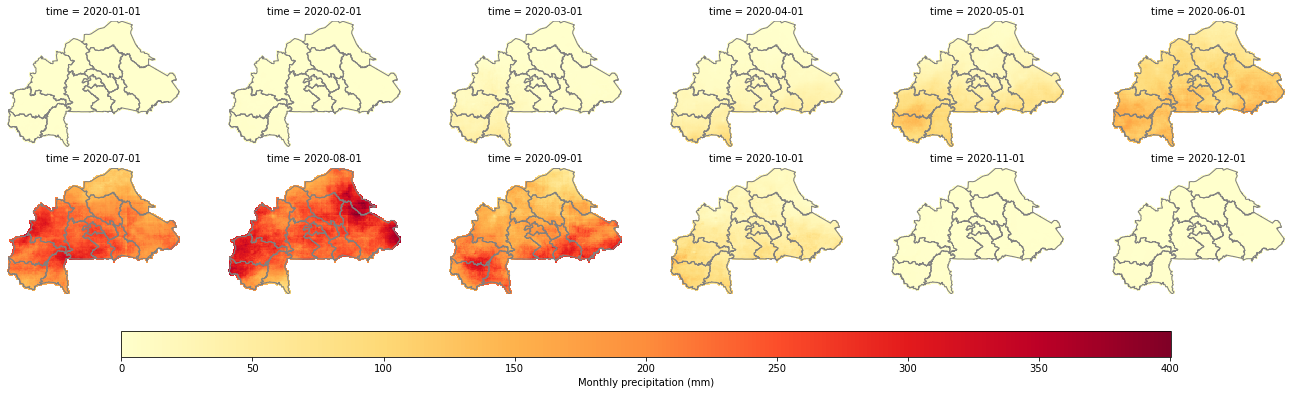

In [5]:
#show distribution of rainfall across months for 2020 to understand rainy season patterns
ds_country=xr.open_dataset(chirps_country_processed_path)
#show the data for each month of 2020, clipped to MWI
g=ds_country.sel(time=ds_country.time.dt.year.isin([2020])).precip.plot(
    col="time",
    col_wrap=6,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
        "label":"Monthly precipitation (mm)"
    },
    cmap="YlOrRd",
)

df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="grey")
    ax.axis("off")

IRI's seasonal forecast is produced as a probability of the rainfall being in the lower tercile, also referred to as being below average. We therefore compute the occurrence of observed below average rainfall.  

Below the areas with below average rainfall for each season ending in 2020 are shown. The date indicates the end of the rainy season, i.e. 2020-06 equals the April-May-June season.

In [6]:
#TODO: change structure ds such that time is divided into a year and a season
ds_season_below=rioxarray.open_rasterio(chirps_seasonal_lower_tercile_processed_path)

In [7]:
ds_season_below

<xarray.Dataset>
Dimensions:      (time: 482, x: 160, y: 114)
Coordinates:
  * time         (time) object 1982-01-01 00:00:00 ... 2020-12-01 00:00:00
  * x            (x) float64 -5.525 -5.475 -5.425 -5.375 ... 2.325 2.375 2.425
  * y            (y) float64 15.07 15.02 14.97 14.92 ... 9.575 9.525 9.475 9.425
    spatial_ref  int64 0
Data variables:
    precip       (time, y, x) float32 ...
Attributes: (12/55)
    latitude#axis:                            Y
    latitude#long_name:                       latitude
    latitude#standard_name:                   latitude
    latitude#units:                           degrees_north
    latitude#_FillValue:                      nan
    longitude#axis:                           X
    ...                                       ...
    spatial_ref#semi_minor_axis:              6356752.314245179
    spatial_ref#spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984...
    time#axis:                                T
    time#calendar:                            proleptic_gregorian
    time#standard_name:                       time
    time#units:                               days since 1982-01-01 00:00:00

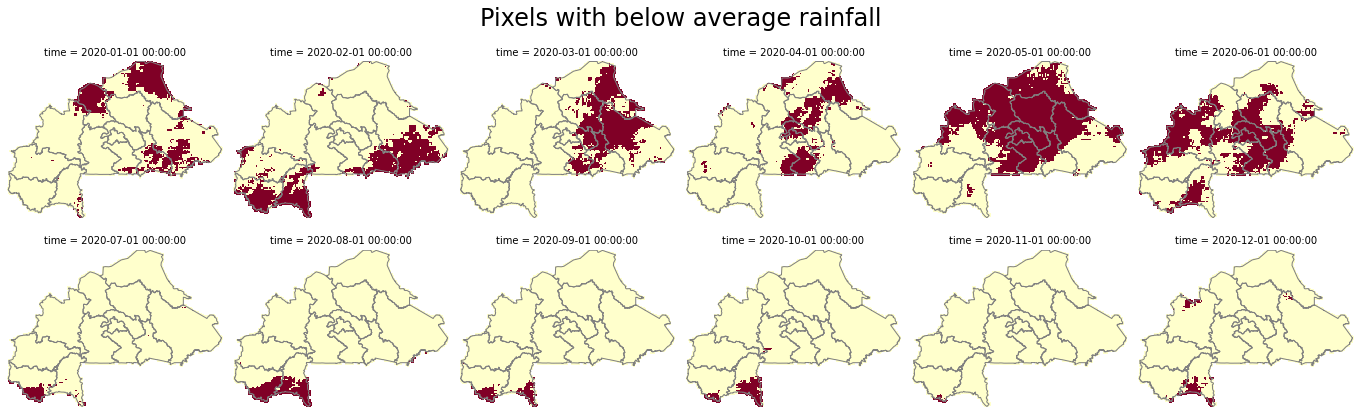

In [8]:
#show the data for each month of 2020, clipped to MWI
#TODO change subplot titles
g=ds_season_below.sel(time=ds_season_below.time.dt.year.isin([2020])).precip.plot(
    col="time",
    col_wrap=6,
    levels=[-666,0],
    add_colorbar=False,
    cmap="YlOrRd",
)

df_bound = gpd.read_file(adm1_bound_path)
for ax in g.axes.flat:
    df_bound.boundary.plot(linewidth=1, ax=ax, color="grey")
    ax.axis("off")
g.fig.suptitle("Pixels with below average rainfall",size=24)
g.fig.tight_layout()

The plots below show the distribution of seasonal rainfall across the whole country (so not only the region of interest). The red line indicates the tercile value averaged across all raster cells. This means it is slightly different for each raster cell, but it helps to get a general feeling

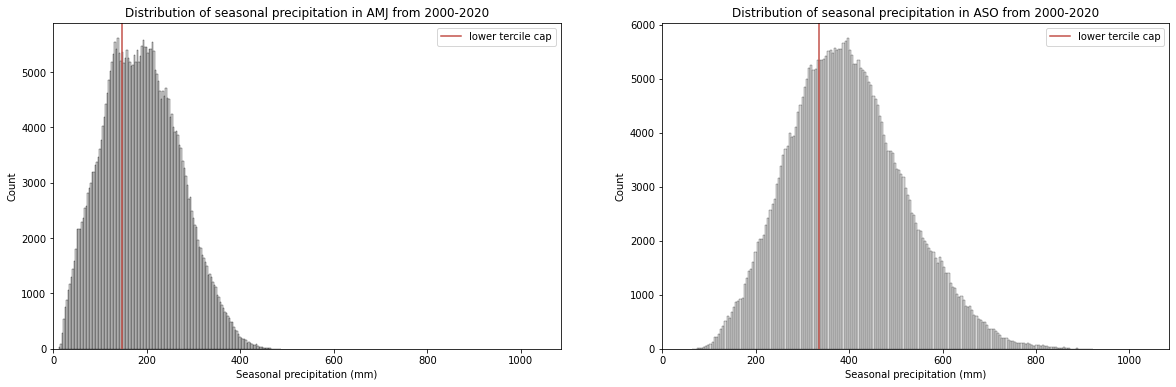

In [9]:
seas_len=3
ds_season=ds_country.rolling(time=seas_len,min_periods=seas_len).sum().dropna(dim="time",how="all")

season_end_months=[6,10]
colp_num=2
num_plots=len(season_end_months)
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(20,6))
for i, m in enumerate(season_end_months):
    ax = fig.add_subplot(rows,colp_num,i+1)
    ds_season_sel=ds_season.sel(time=ds_season.time.dt.month==m)
    g=sns.histplot(ds_season_sel.precip.values.flatten(),color="#CCCCCC",ax=ax)
    perc=np.percentile(ds_season_sel.precip.values.flatten()[~np.isnan(ds_season_sel.precip.values.flatten())], 33)
    plt.axvline(perc,color="#C25048",label="lower tercile cap")
    ax.legend()
    ax.set(xlabel="Seasonal precipitation (mm)")
    ax.set_title(f"Distribution of seasonal precipitation in {month_season_mapping[m]} from 2000-2020")
    ax.set_xlim(0,np.nanmax(ds_season.precip.values))

Now that we have analyzed the data on pixel level, we aggregate to the area of interest. This area is the total area of the 4 admin1s: Boucle de Mounhoun, Centre Nord, Sahel, and Nord   
We compute the percentage of the area having experienced below average rainfall for each season.   
We can see that about 1/3 of the time none of the area experiences below average rainfall.   
Logically, it is less likely that larger areas have below average rainfall. However, this diminishment is relatively small, indicating geographical correlation.

In [10]:
def compute_zonal_stats_xarray(raster,shapefile,lon_coord="lon",lat_coord="lat",var_name="prob"):
    raster_clip=raster.rio.set_spatial_dims(x_dim=lon_coord,y_dim=lat_coord).rio.clip(shapefile.geometry.apply(mapping),raster.rio.crs,all_touched=False)
    raster_clip_bavg=raster_clip.where(raster_clip[var_name] >=0)
    grid_mean = raster_clip_bavg.mean(dim=[lon_coord,lat_coord]).rename({var_name: "mean_cell"})
    grid_min = raster_clip_bavg.min(dim=[lon_coord,lat_coord]).rename({var_name: "min_cell"})
    grid_max = raster_clip_bavg.max(dim=[lon_coord,lat_coord]).rename({var_name: "max_cell"})
    grid_std = raster_clip_bavg.std(dim=[lon_coord,lat_coord]).rename({var_name: "std_cell"})
    grid_quant90 = raster_clip_bavg.quantile(0.9,dim=[lon_coord,lat_coord]).rename({var_name: "10quant_cell"})
    grid_percbavg = raster_clip_bavg.count(dim=[lon_coord,lat_coord])/raster_clip.count(dim=[lon_coord,lat_coord])*100
    grid_percbavg=grid_percbavg.rename({var_name: "bavg_cell"})
    zonal_stats_xr = xr.merge([grid_mean, grid_min, grid_max, grid_std,grid_quant90,grid_percbavg]).drop("spatial_ref")
    zonal_stats_df=zonal_stats_xr.to_dataframe()
    zonal_stats_df=zonal_stats_df.reset_index()
    zonal_stats_df=zonal_stats_df.drop("quantile",axis=1)
    return zonal_stats_df

In [11]:
gdf_adm1=gpd.read_file(adm1_bound_path)
#select the adms of interest
gdf_reg=gdf_adm1[gdf_adm1.ADM1_FR.isin(adm_sel)]

In [12]:
#compute stats
df_stats_reg=compute_zonal_stats_xarray(ds_season_below,gdf_reg,lon_coord="x",lat_coord="y",var_name="precip")
#some dates don't have forecasted values due to dry mask, remove these
df_stats_reg=df_stats_reg.dropna(subset=["mean_cell"])
df_stats_reg["end_time"]=pd.to_datetime(df_stats_reg["time"].apply(lambda x: x.strftime('%Y-%m-%d')))
df_stats_reg["end_month"]=df_stats_reg.end_time.dt.to_period("M")
df_stats_reg["start_time"]=df_stats_reg.end_time.apply(lambda x: x+relativedelta(months=-2))
df_stats_reg["start_month"]=df_stats_reg.start_time.dt.to_period("M")

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [13]:
perc_obs_bavg_1in3 = int(np.percentile(df_stats_reg.bavg_cell, 66)) #round cause later on used as threshold
glue("perc_obs_bavg_1in3", perc_obs_bavg_1in3)

43

If we would use a threshold on the percentage of the area that experiences below average rainfall such that it is a 1 in 3 year event, this threshold would be {glue:text}`perc_obs_bavg_1in3`%

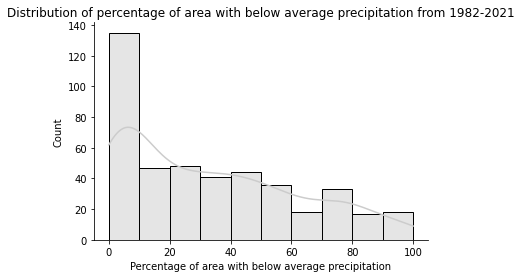

In [14]:
#plot distribution of area with below avg rainfall
g=sns.histplot(df_stats_reg.bavg_cell,kde=True,color="#CCCCCC")
sns.despine()
g.set(xlabel="Percentage of area with below average precipitation")
plt.title("Distribution of percentage of area with below average precipitation from 1982-2021");

In [15]:
threshold_for_prob=40
glue("threshold_for_prob", threshold_for_prob)

40

## Correlate the observations with forecasts
Now that we have analyzed the observational data, we can investigate the correspondence between observed and forecasted values.  
With the forecasts there is an extra variable, namely the minimum probability of below average rainfall. Since a part of the trigger is based on this being {glue:text}`threshold_for_prob`%, this is also the value used in this analysis.

In [16]:
#load forecast data, computed in `bfa_iriforecast.md`
df_for=pd.read_csv(stats_reg_for_path,parse_dates=["F"])
def get_forecastmonth(pub_month,leadtime):
    return pub_month+relativedelta(months=+int(leadtime))
df_for["for_start"]=df_for.apply(lambda x: get_forecastmonth(x.F,x.L), axis=1)
df_for["for_start_month"]=df_for.for_start.dt.to_period("M")
df_for["for_end_month"]=df_for.apply(lambda x: get_forecastmonth(x.for_start,2), axis=1)

In [17]:
#only select values for below average rainfall
df_for_bavg=df_for[df_for.C==0]

In [18]:
#merge observed and forecasted
df_obsfor=df_stats_reg.merge(df_for_bavg,left_on="start_month",right_on="for_start_month",suffixes=("_obs","_for"))
#add season mapping
df_obsfor["season"]=df_obsfor.for_end_month.apply(lambda x:month_season_mapping[x.month])
#used for plotting
df_obsfor["seas_year"]=df_obsfor.apply(lambda x: f"{x.season} {x.for_end_month.year}",axis=1)

In [19]:
df_obsfor.head()

,time,mean_cell_obs,min_cell_obs,max_cell_obs,std_cell_obs,10quant_cell_obs,bavg_cell,end_time,end_month,start_time,...,std_cell_for,10quant_cell_for,quantile,40percth_cell,month,for_start,for_start_month,for_end_month,season,seas_year
0,2018-01-01 00:00:00,1.196803,0.229523,3.945843,0.872724,2.686345,41.159830,2018-01-01,2018-01,2017-11-01,...,0.444737,35.843451,0.9,0.0,7,2017-11-16,2017-11,2018-01-16,NDJ,NDJ 2018
1,2018-01-01 00:00:00,1.196803,0.229523,3.945843,0.872724,2.686345,41.159830,2018-01-01,2018-01,2017-11-01,...,1.067100,35.281911,0.9,0.0,8,2017-11-16,2017-11,2018-01-16,NDJ,NDJ 2018
2,2018-01-01 00:00:00,1.196803,0.229523,3.945843,0.872724,2.686345,41.159830,2018-01-01,2018-01,2017-11-01,...,0.044833,34.958657,0.9,0.0,9,2017-11-16,2017-11,2018-01-16,NDJ,NDJ 2018
3,2018-01-01 00:00:00,1.196803,0.229523,3.945843,0.872724,2.686345,41.159830,2018-01-01,2018-01,2017-11-01,...,0.210957,36.902707,0.9,0.0,10,2017-11-16,2017-11,2018-01-16,NDJ,NDJ 2018
4,2019-01-01 00:00:00,1.416060,0.229509,4.311447,0.986867,2.948182,47.241867,2019-01-01,2019-01,2018-11-01,...,0.408963,38.385670,0.9,0.0,7,2018-11-16,2018-11,2019-01-16,NDJ,NDJ 2019


As first comparison we can make a density plot of the area forecasted to have >=40% probability of below average precipitaiton, and the percentage of the area that observed below average precipitation.   

As the plot below shows, these results are not very promissing. Only in a few seasons there was a >=40% probability of below average precipitation, and in most of those seasons, the percentage of the area that also observed the below average precipitation was relatively low.

In [20]:
glue("pears_corr", df_obsfor[(df_obsfor.C==0)&(df_obsfor.L==1)].corr().loc["bavg_cell","40percth_cell"])

-0.15987708547765622

We can also capture the relation between the two variables in one number by looking at the Pearson correlation. This is found to be {glue:text}`pears_corr:.2f`. This indicates a weak and even negative correlation, which is the opposite from what we would expect.

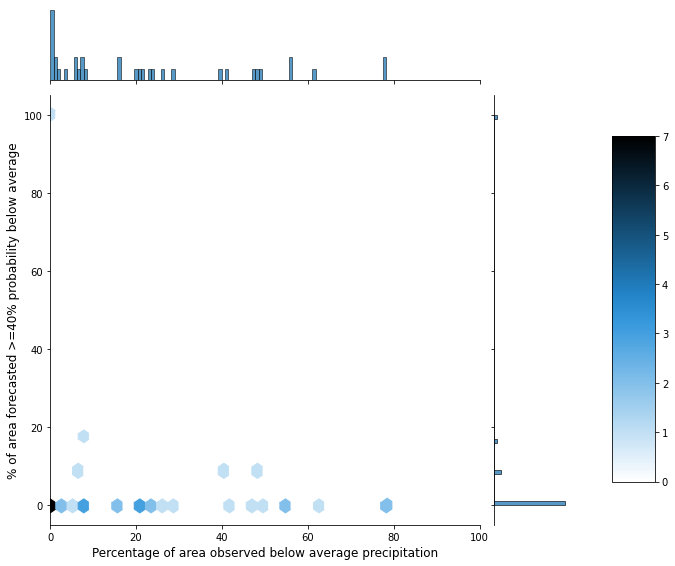

In [21]:
 #plot the observed vs forecast-observed for obs<=2mm
g=sns.jointplot(data=df_obsfor[(df_obsfor.L==1)],x="bavg_cell",y=f"{threshold_for_prob}percth_cell", kind="hex",height=12,marginal_kws=dict(bins=100),joint_kws=dict(gridsize=30),xlim=(0,100))
g.set_axis_labels("Percentage of area observed below average precipitation", "% of area forecasted >=40% probability below average", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])
plt.colorbar(cax=cbar_ax);

It would be possible that the observed and forecasted below average seasons don't fully overlap, but are close in time. To understand this better, we create a bar plot showing the percentage of the area with below average precipitation for the forecasted and observed values. We can see from here that the overlap is poor. 

Note:
1) the forecasted percentage, is the percentage of the area where the probability of below average >=40
2) some seasons are not included due to the dry mask defined by IRI

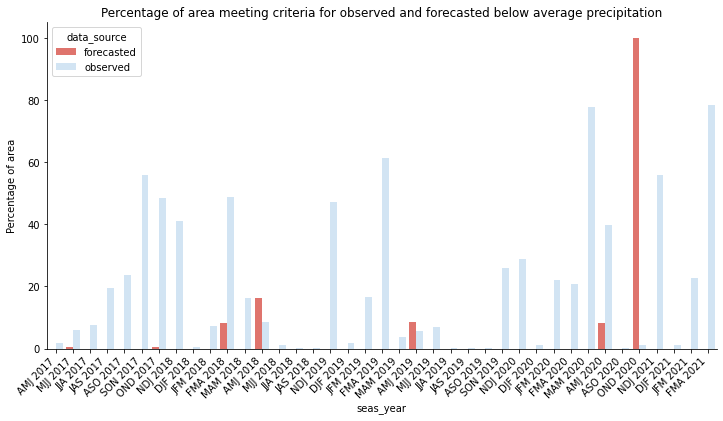

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
tidy = df_obsfor.loc[df_obsfor.L==1,["seas_year","for_start","40percth_cell","bavg_cell"]].rename(columns={"40percth_cell":"forecasted","bavg_cell":"observed"}).melt(id_vars=['for_start','seas_year'],var_name="data_source").sort_values("for_start")
tidy.rename(columns={"40percth_cell":"forecasted","bavg_cell":"observed"},inplace=True)
sns.barplot(x='seas_year', y='value', data=tidy, ax=ax,hue="data_source",palette={"observed":"#CCE5F9","forecasted":'#F2645A'})
sns.despine(fig)
x_dates = tidy.seas_year.unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right');
ax.set_ylabel("Percentage of area")
ax.set_title("Percentage of area meeting criteria for observed and forecasted below average precipitation");

Despite the bad correlation, we do a bit further exploration to see if the geographical spread of the forecasted and observed below average area matters. 
Since it occurs so rarely that any part of the area is forecasted to have >=40% probability of below average rainfall, we define the forecast as meeting the criterium if at least 1% of the area meets the 40% threshold. This occurred 5 times during the last 4 years (=12% of the time).

We then experiment with different thresholds of the area that had observed below average precipitation. As can be seen, with any threshold the miss and false alarm rate are really high, showing bad detection. 

Note: these numbers are not at all statistically significant!!

In [23]:
df_obsfor[f"max_cell_{threshold_for_prob}"]=np.where(df_obsfor.max_cell_for>=threshold_for_prob,1,0)

threshold_area_list=[1,50,20,35]
for t in threshold_area_list:
    df_obsfor[f"obs_bavg_{t}"]=np.where(df_obsfor.bavg_cell>=t,1,0)
    df_obsfor[f"for_bavg_{t}"]=np.where(df_obsfor["40percth_cell"]>=t,1,0)

In [24]:
df_obsfor_l1=df_obsfor[df_obsfor.L==1].dropna()

In [25]:
#compute tp,tn,fp,fn per threshold
for_thresh=1
y_predicted = np.where(df_obsfor_l1["40percth_cell"]>=for_thresh,1,0)
threshold_list=np.arange(0,df_obsfor_l1.bavg_cell.max() +6,5)
df_pr_th=pd.DataFrame(threshold_list,columns=["threshold"]).set_index('threshold')
for t in threshold_list:
    y_target = np.where(df_obsfor_l1.bavg_cell>=t,1,0)
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
    #fn=not forecasted bavg but was observed
    tn,fp,fn,tp=cm.flatten()
    df_pr_th.loc[t,["month_miss_rate","month_false_alarm_rate"]]=fn/(tp+fn+0.00001)*100,fp/(tp+fp+0.00001)*100
    df_pr_th.loc[t,["tn","tp","fp","fn"]]=tn,tp,fp,fn
df_pr_th=df_pr_th.reset_index()

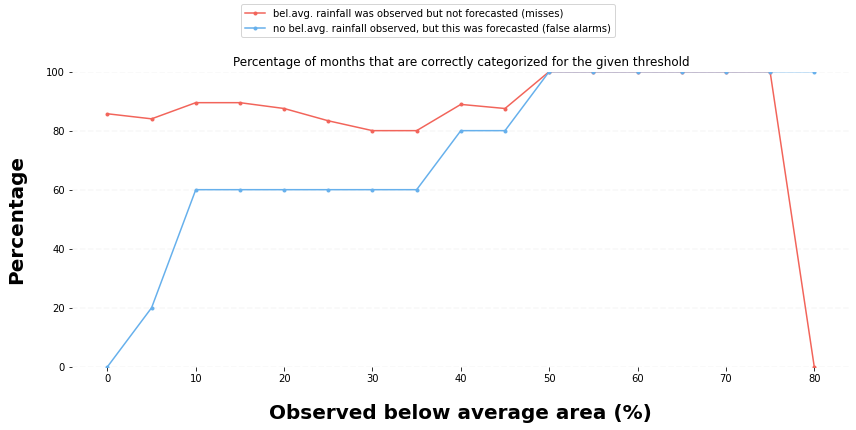

In [26]:
fig,ax=plt.subplots()

df_pr_th.plot(x="threshold",y="month_miss_rate" ,figsize=(12, 6), color='#F2645A',legend=False,ax=ax,style='.-',label="bel.avg. rainfall was observed but not forecasted (misses)")
df_pr_th.plot(x="threshold",y="month_false_alarm_rate" ,figsize=(12, 6), color='#66B0EC',legend=False,ax=ax,style='.-',label="no bel.avg. rainfall observed, but this was forecasted (false alarms)")

ax.set_xlabel("Observed below average area (%)", labelpad=20, weight='bold', size=20)
ax.set_ylabel("Percentage", labelpad=20, weight='bold', size=20)
sns.despine(bottom=True,left=True)
ax.set_ylim(0,100)

# Draw vertical axis lines
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

plt.title(f"Percentage of months that are correctly categorized for the given threshold")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
fig.tight_layout(rect=(0,0,1,0.9))

Since the error rates are relatively the smalles at 35% of the area having observed below average precipitaiton, we plot the confusion matrix for this value. We can see that with this threshold 20% of the seasons with below average rainfall is detected, and 60% of the "activations" would be false alarms

When separating by season and zooming in on our seasons of interest, the numbers are very different. During AMJ only once below average precipitation was observed, and this was also forecasted. However, 2/3 seasons that were forecasted to have bel.avg. this was not observed. During ASO no occurrence of below average precipitation was seen nor forecasted. 

Note: these numbers are not at all statistically significant!!

In [27]:
def compute_confusionmatrix(df,target_var,predict_var, ylabel,xlabel,col_var=None,colp_num=3,title=None,figsize=(20,15)):
    #number of dates with observed dry spell overlapping with forecasted per month
    if col_var is not None:
        num_plots = len(df[col_var].unique())
    else:
        num_plots=1
    if num_plots==1:
        colp_num=1
    rows = math.ceil(num_plots / colp_num)
    position = range(1, num_plots + 1)
    fig=plt.figure(figsize=figsize)
    if col_var is not None:
        for i, m in enumerate(df.sort_values(by=col_var)[col_var].unique()):
            ax = fig.add_subplot(rows,colp_num,i+1)
            y_target =    df.loc[df[col_var]==m,target_var]
            y_predicted = df.loc[df[col_var]==m,predict_var]
            cm = confusion_matrix(y_target=y_target, 
                                  y_predicted=y_predicted)

            plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax,class_names=["No","Yes"])
            ax.set_ylabel(ylabel)
            ax.set_xlabel(xlabel)
            ax.set_title(f"{col_var}={m}")
    else:
        ax = fig.add_subplot(rows,colp_num,1)
        y_target =    df[target_var]
        y_predicted = df[predict_var]
        cm = confusion_matrix(y_target=y_target, 
                              y_predicted=y_predicted)

        plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax,class_names=["No","Yes"])
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        
    if title is not None:
        fig.suptitle(title)
    fig.tight_layout()
    return fig

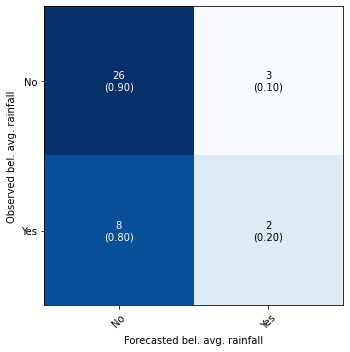

In [28]:
cm_thresh=compute_confusionmatrix(df_obsfor[df_obsfor.L==1],f"obs_bavg_35",f"for_bavg_1","Observed bel. avg. rainfall","Forecasted bel. avg. rainfall",figsize=(5,5))

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


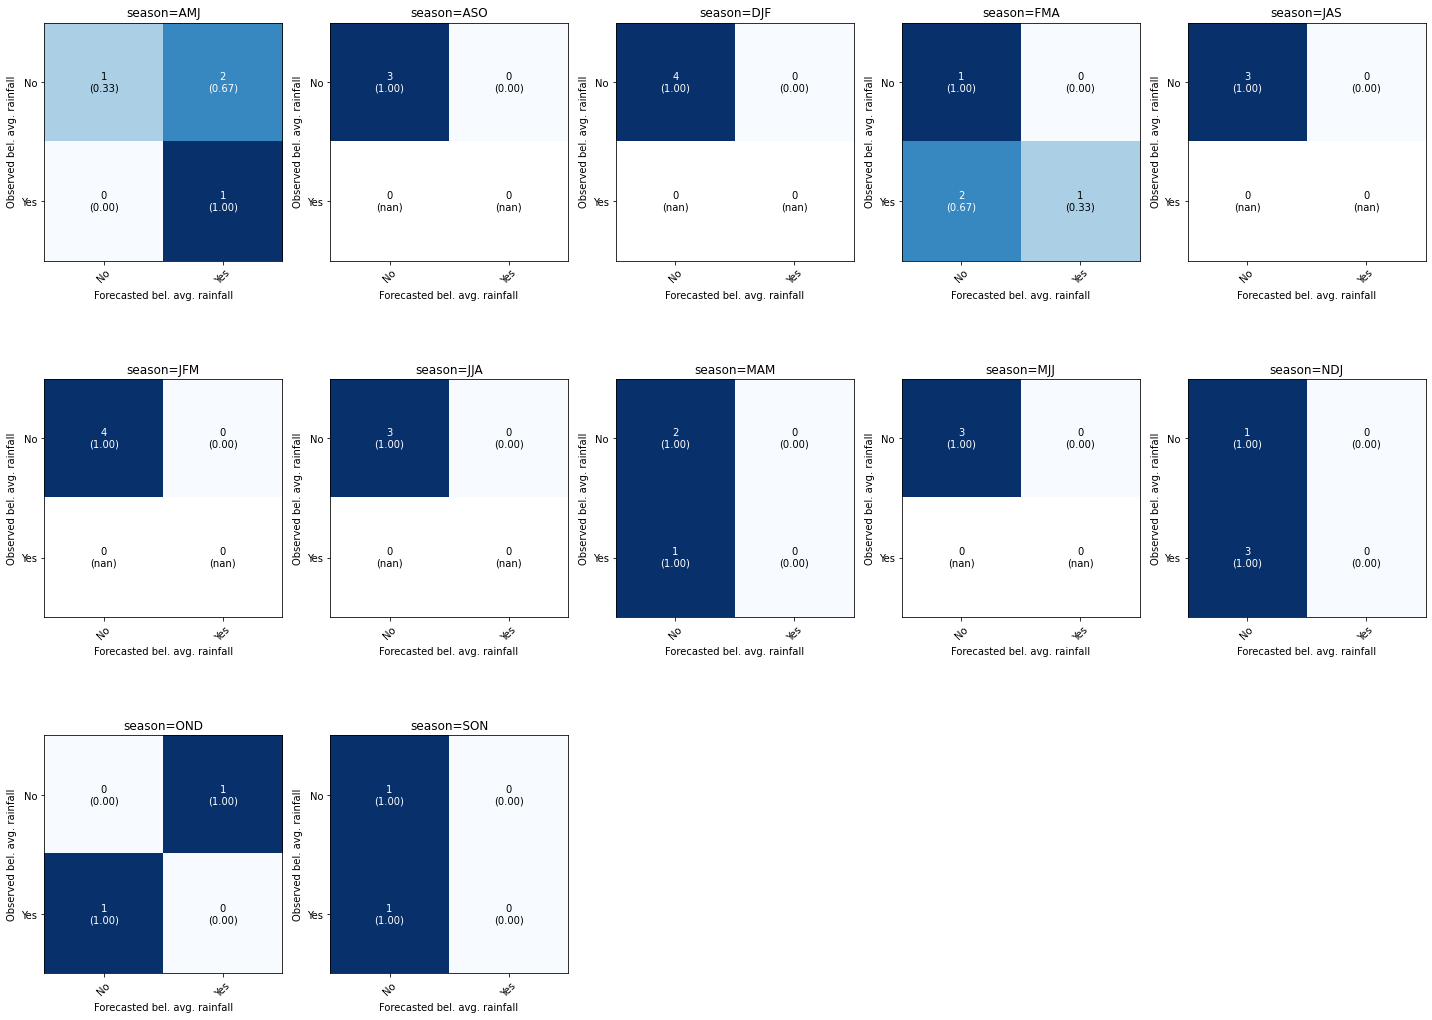

In [29]:
cm_thresh=compute_confusionmatrix(df_obsfor[df_obsfor.L==1],f"obs_bavg_35",f"for_bavg_1","Observed bel. avg. rainfall","Forecasted bel. avg. rainfall",col_var="season",colp_num=5)

## Conclusion

The forecasted and observed values don't show a great overlap for our threshold and area of interest.    
One limitation of these numbers is the low statistical significance due to very limited data availability.   
If we want to continue understanding the suitability of this trigger, we therefore might want to look for ideas on how we could make them statistically significant. One idea could be to do the analysis at the raster cell level instead of aggregating to the area of interst.

## Archive

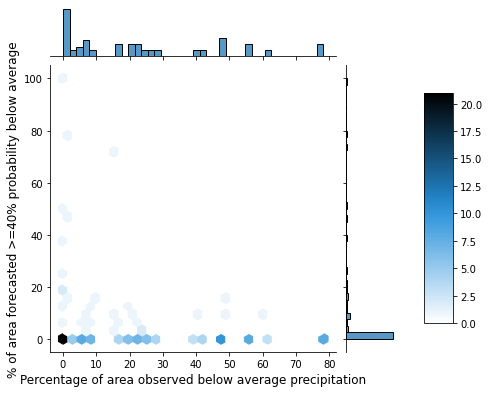

In [30]:
 #plot the observed vs forecast-observed
g=sns.jointplot(data=df_obsfor[(df_obsfor.C==0)],x="bavg_cell",y=f"{threshold_for_prob}percth_cell", kind="hex",height=8,marginal_kws=dict(bins=40))
g.set_axis_labels("Percentage of area observed below average precipitation", "% of area forecasted >=40% probability below average", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])
plt.colorbar(cax=cbar_ax)

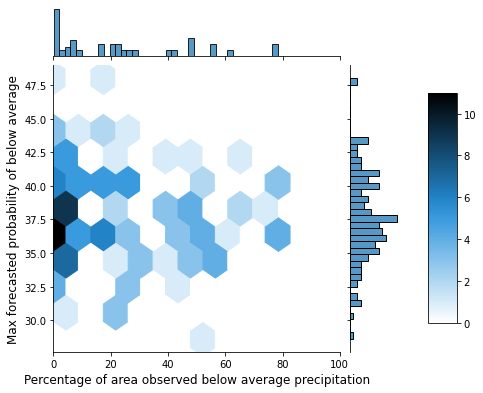

In [31]:
 #plot the observed vs forecast-observed for obs<=2mm
g=sns.jointplot(data=df_obsfor[(df_obsfor.C==0)],x="bavg_cell",y="max_cell_for", kind="hex",height=8,marginal_kws=dict(bins=40),xlim=(0,100))#,ylim=(0,100))
g.set_axis_labels("Percentage of area observed below average precipitation", "Max forecasted probability of below average", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])
plt.colorbar(cax=cbar_ax)

<AxesSubplot:xlabel='for_start', ylabel='40percth_cell'>

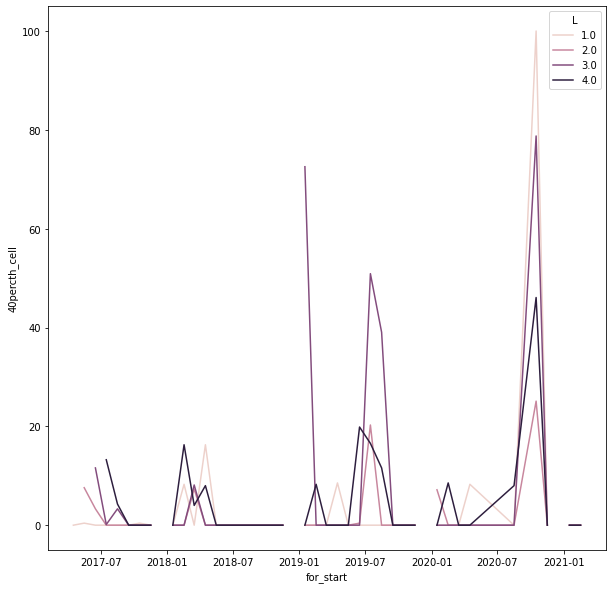

In [32]:
fig,ax=plt.subplots(figsize=(10,10))
sns.lineplot(data=df_obsfor, x="for_start", y="40percth_cell", hue="L",ax=ax)
# sns.lineplot(data=df_obsfor, x="time",y="bavg_cell",ax=ax,linestyle="--",marker="o")

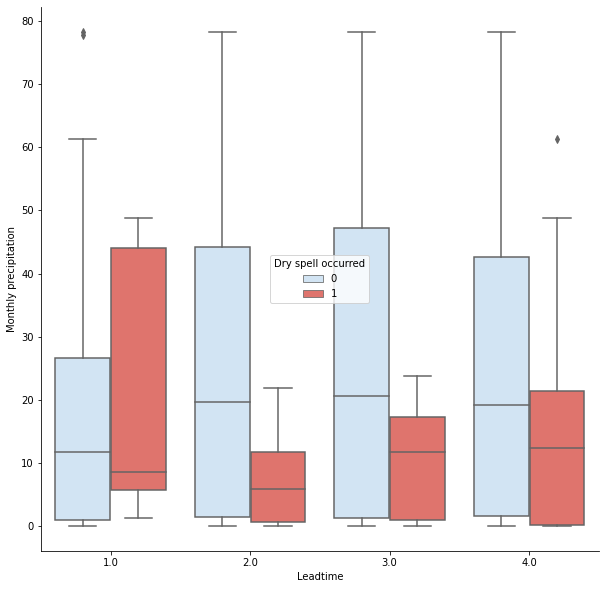

In [33]:
#plot distribution precipitation with and without observed belowavg precip
fig,ax=plt.subplots(figsize=(10,10))
g=sns.boxplot(data=df_obsfor[df_obsfor.C==0],x="L",y="bavg_cell",ax=ax,color="#66B0EC",hue="max_cell_40",palette={0:"#CCE5F9",1:'#F2645A'})
ax.set_ylabel("Monthly precipitation")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Leadtime")
ax.get_legend().set_title("Dry spell occurred")